## Basic analysis of tracking data from CsChrimson experiments in free walking arena

#### Note: This script should be used for data collected using the a stimulation protocol generated by optogeneticsProtocol_quadrantAssay_round2.py (quadrant stimulation before 5s full-field continuous stimulation)

In [1]:
from scipy.io import loadmat
from csv import reader
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
from scipy import sparse as sps
from scipy.stats import ttest_1samp

from os import mkdir

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Set experiment parameter

In [3]:
ledLevelColor = ['black','mediumvioletred','slateblue']

In [50]:
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/\
10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED10/'
#fileName = '20xCsChr_x_HC-Gal4_female_1LEDpower_repeat1_cam_0_date_2015_09_20_time_15_05_46_v001.mat'

analysisDir = baseDir

# CAUTION: Check ufmf video frame rate (default: 20 Hz) and video frame size (default: 1280,1024 pixels).
# Adjust parameters below accrodingly, if necessary.

fps = 20 # 30 # Video sampling rate
imageSizePx = (1280,1024) # (1008,1000) # size of the recorded frames in pixel 

In [51]:
# Quadrant stimulation
stimSecQ = 30
pauseSecQ = 10
numRepeatQ = 3 # repeats x 2 patterns

# Continuous full-field stimulation
stimSecC = 1
pauseSecC = 29
numRepeatC = 1

pixel2mm = 900/225

keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

##### Load file list and first frame numbers

In [52]:
expListFile = baseDir + 'firstFrames.csv'
print('Reading in stimulation start frame list from ' + expListFile)

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []

for line in csv_fileList:
    fileNames.append(line[1])
    startFrames.append(line[2])

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED10/firstFrames.csv


In [53]:
fileNames

['10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat6_cam_0_date_2017_03_13_time_18_33_37_v001',
 '10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat2_cam_0_date_2017_02_24_time_20_02_52_v001',
 '10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat3_cam_0_date_2017_03_02_time_19_07_09_v001',
 '10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat1_cam_0_date_2017_01_31_time_22_42_29_v001',
 '10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat4_cam_0_date_2017_03_03_time_17_53_05_v001',
 '10xChrRWTB_x_HC-Gal4_male_Wuerzburg_10LEDpower_repeat5_cam_0_date_2017_03_06_time_20_38_03_v001']

10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat5


/Users/hannah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat6
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat2
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat3
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat1
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
10LEDpower_repeat4


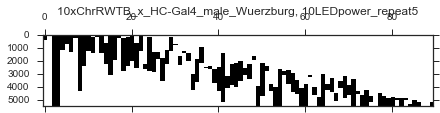

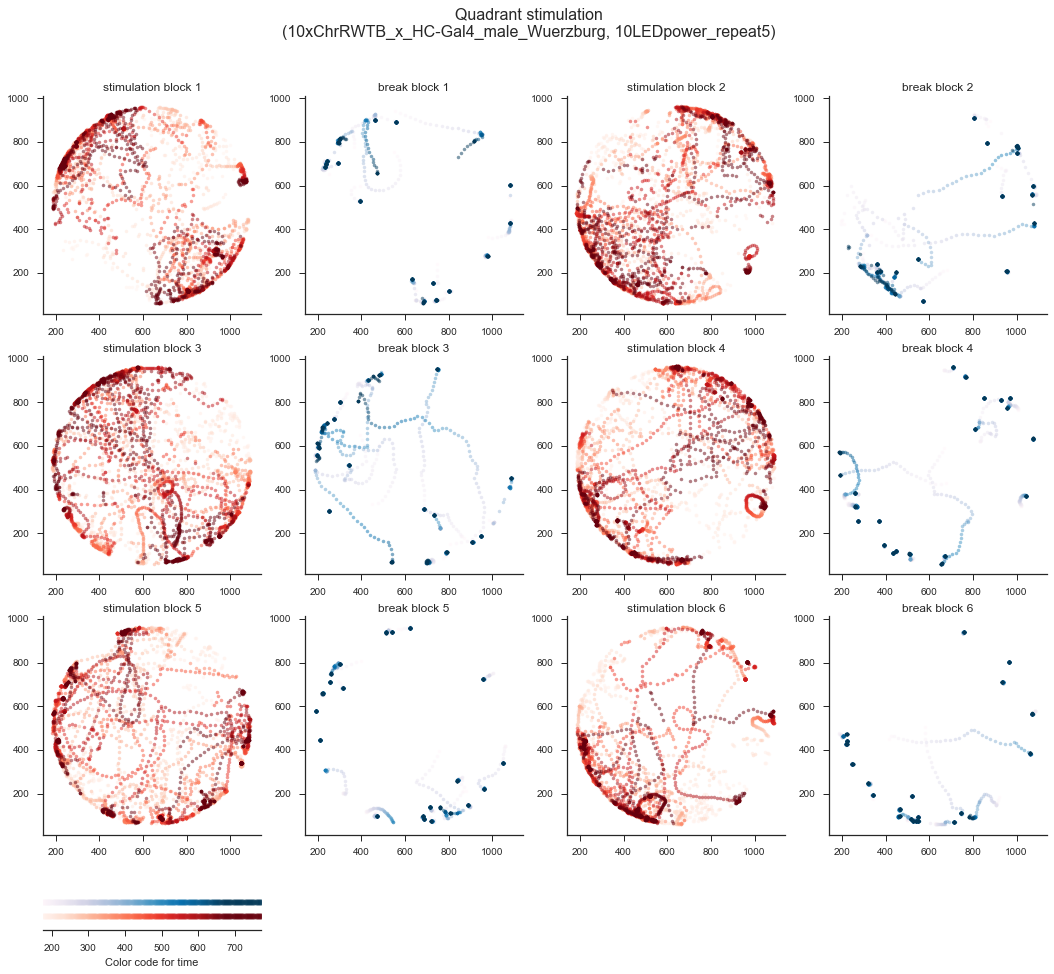

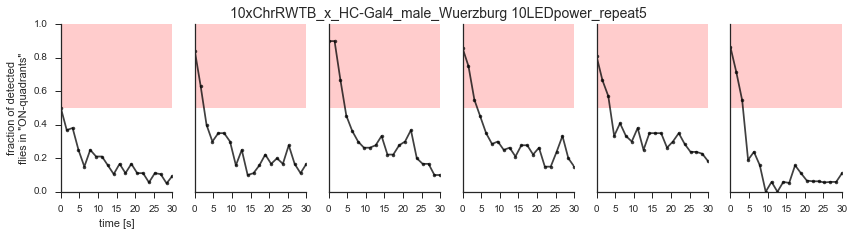

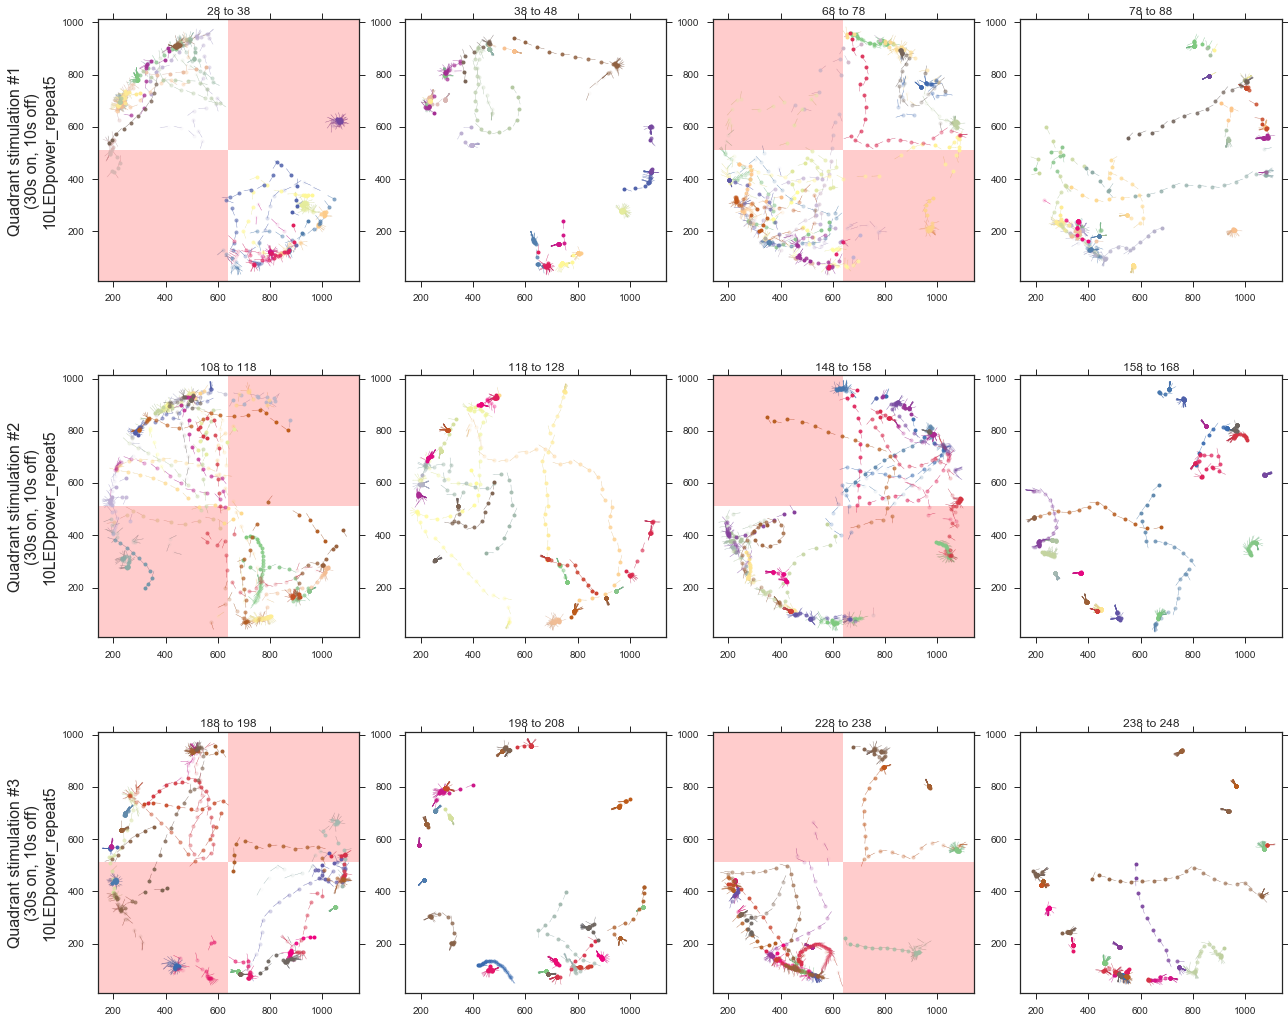

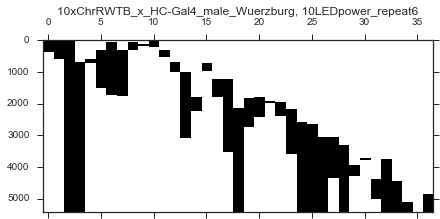

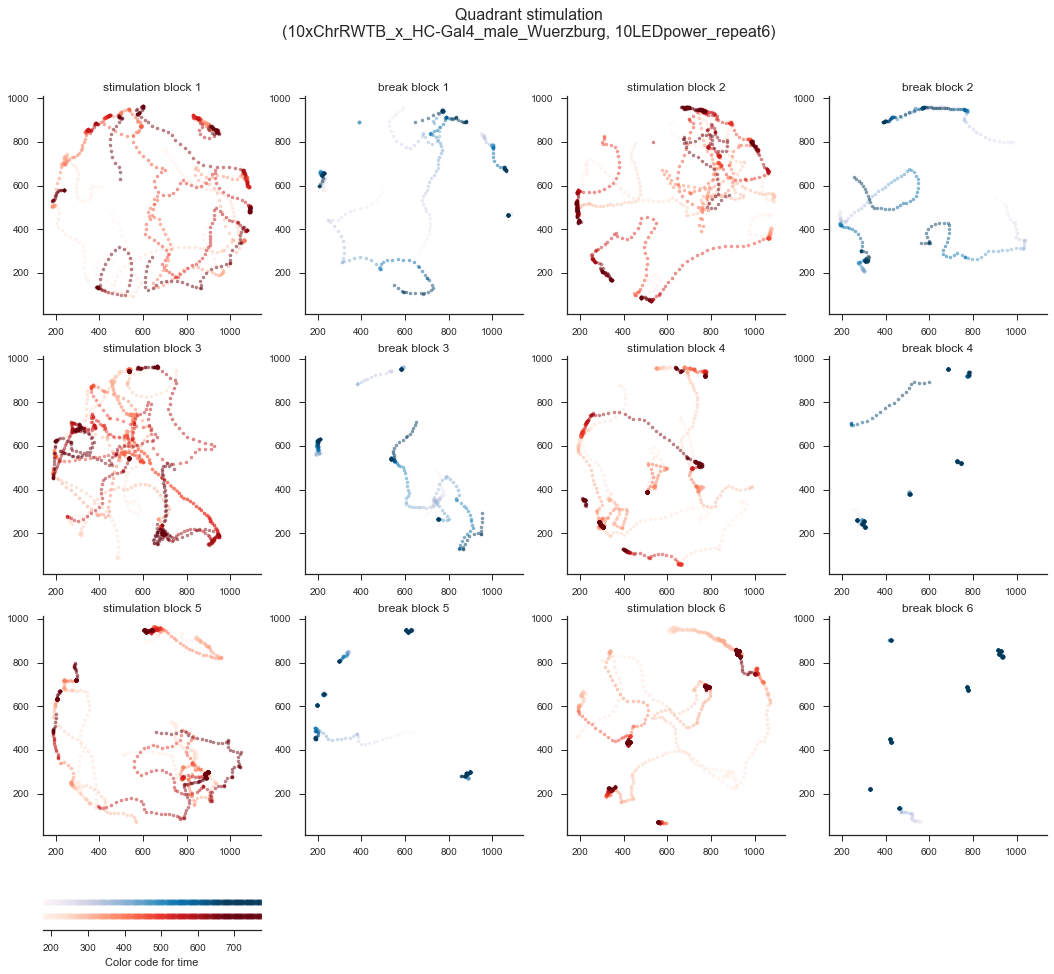

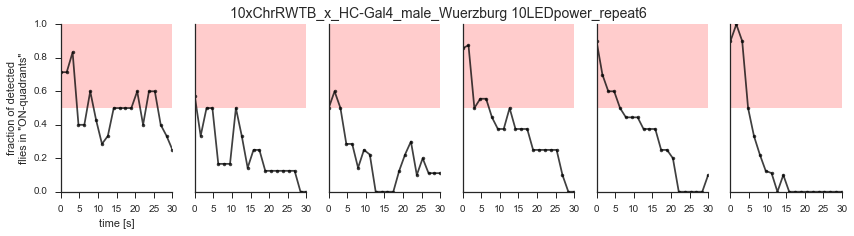

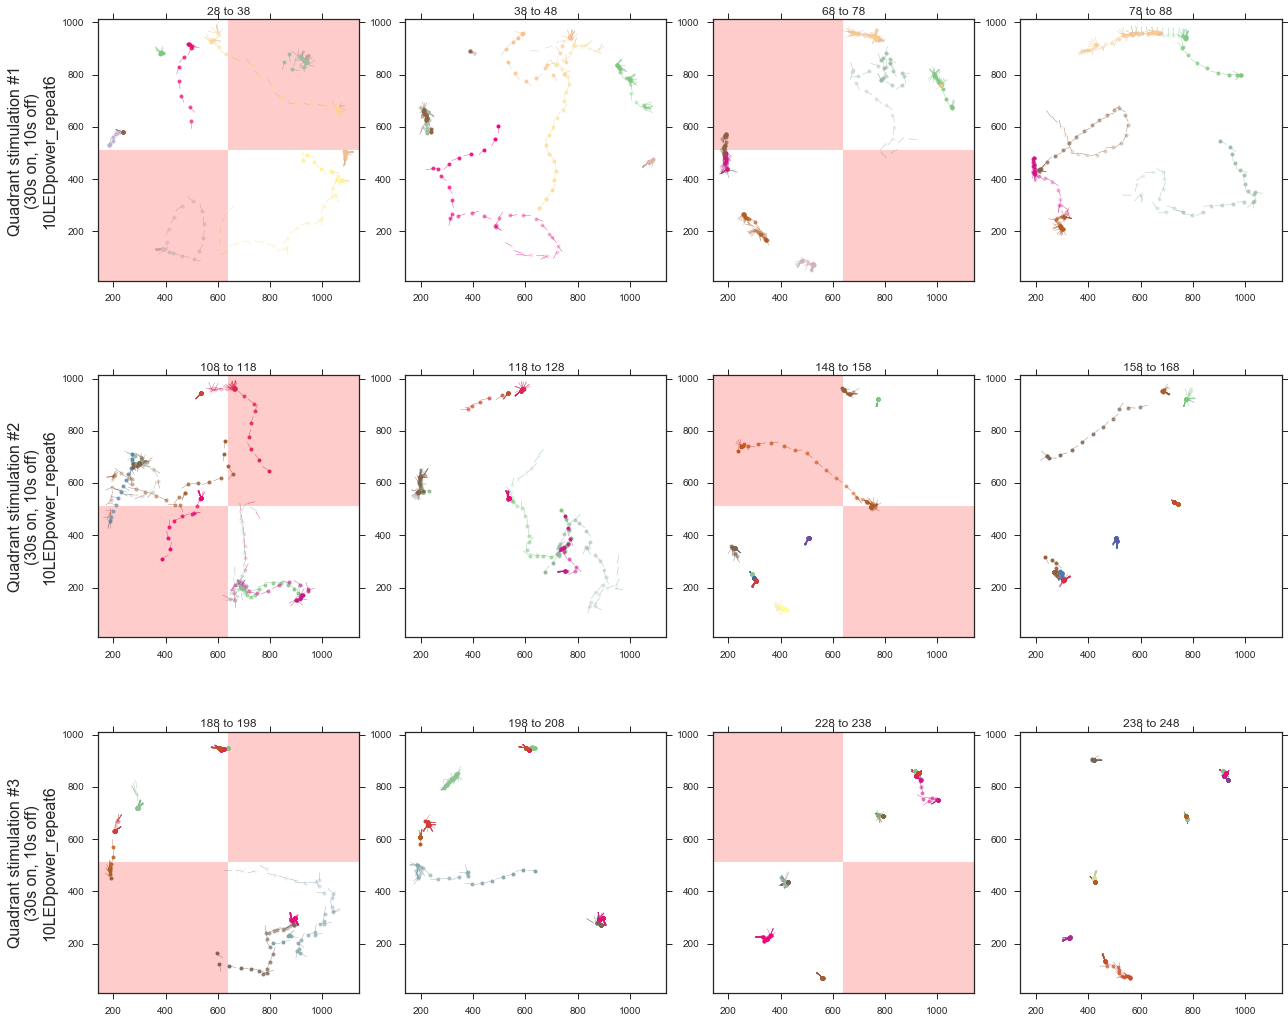

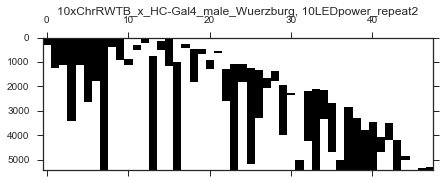

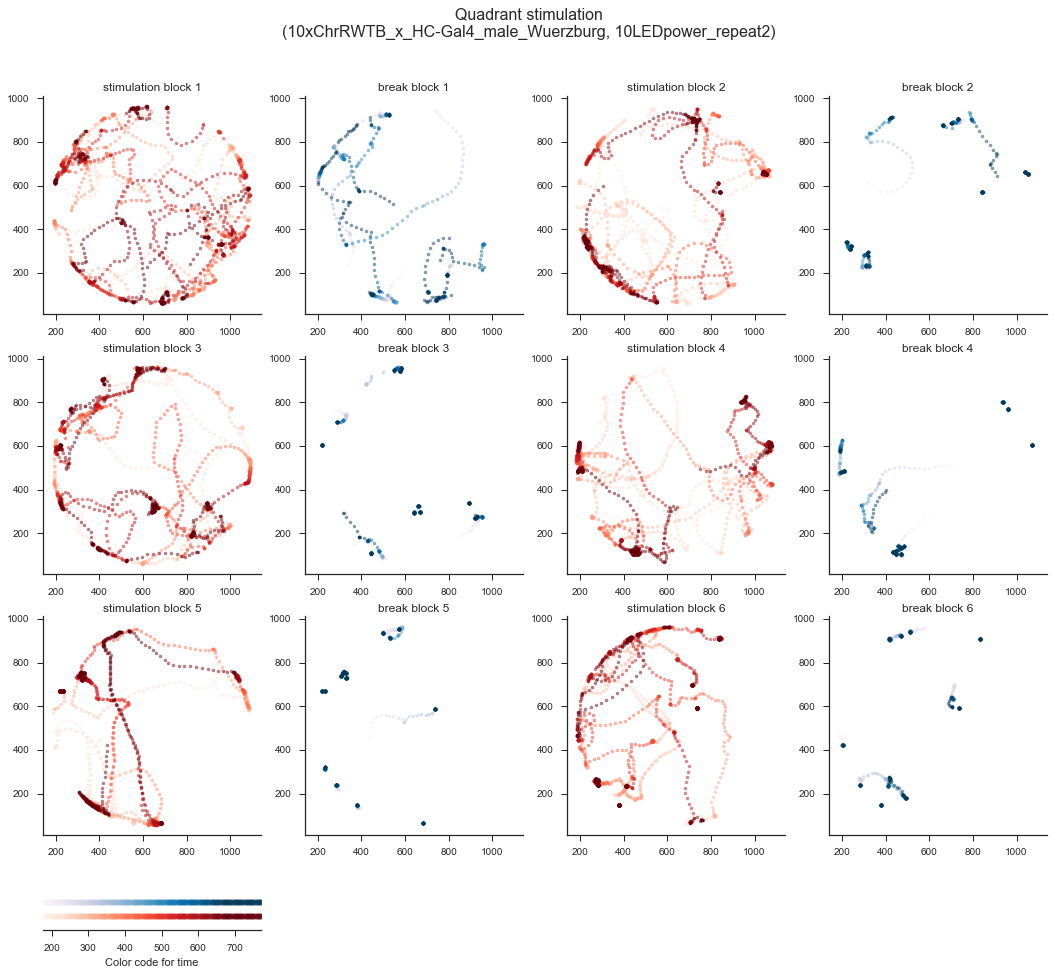

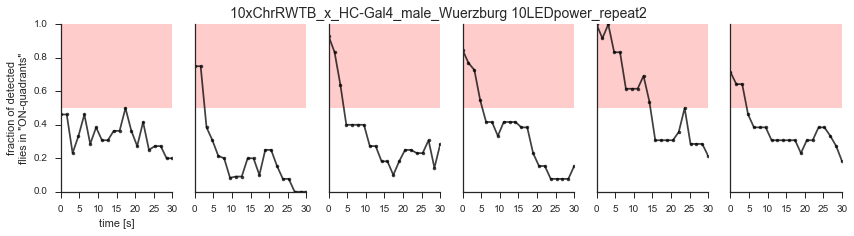

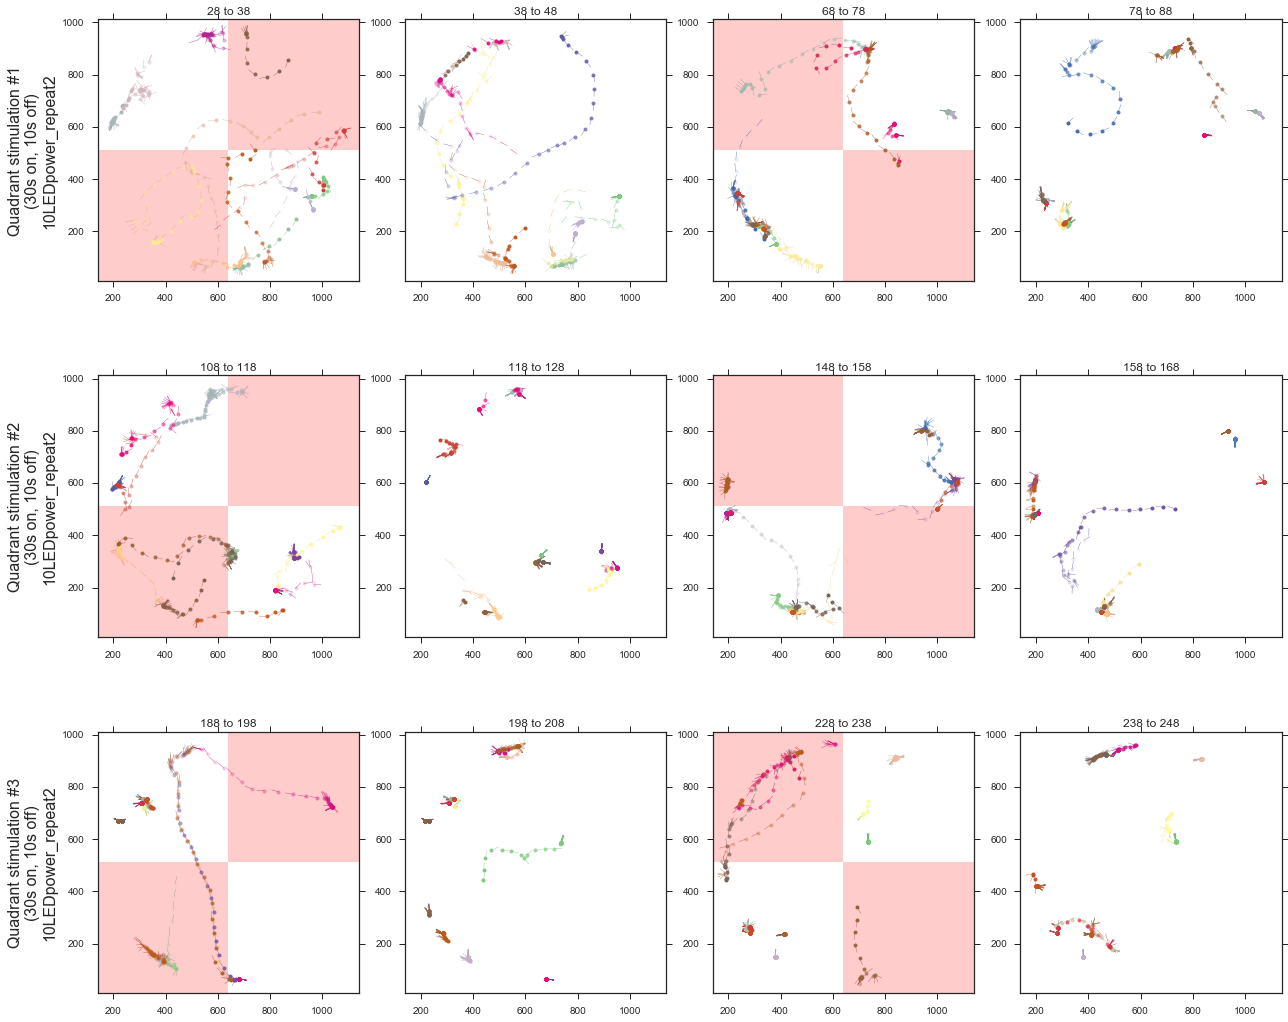

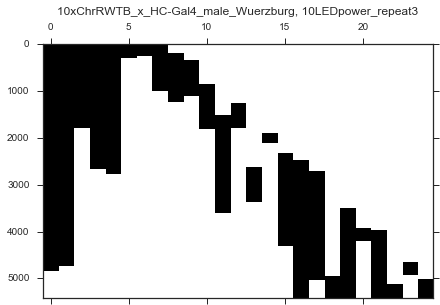

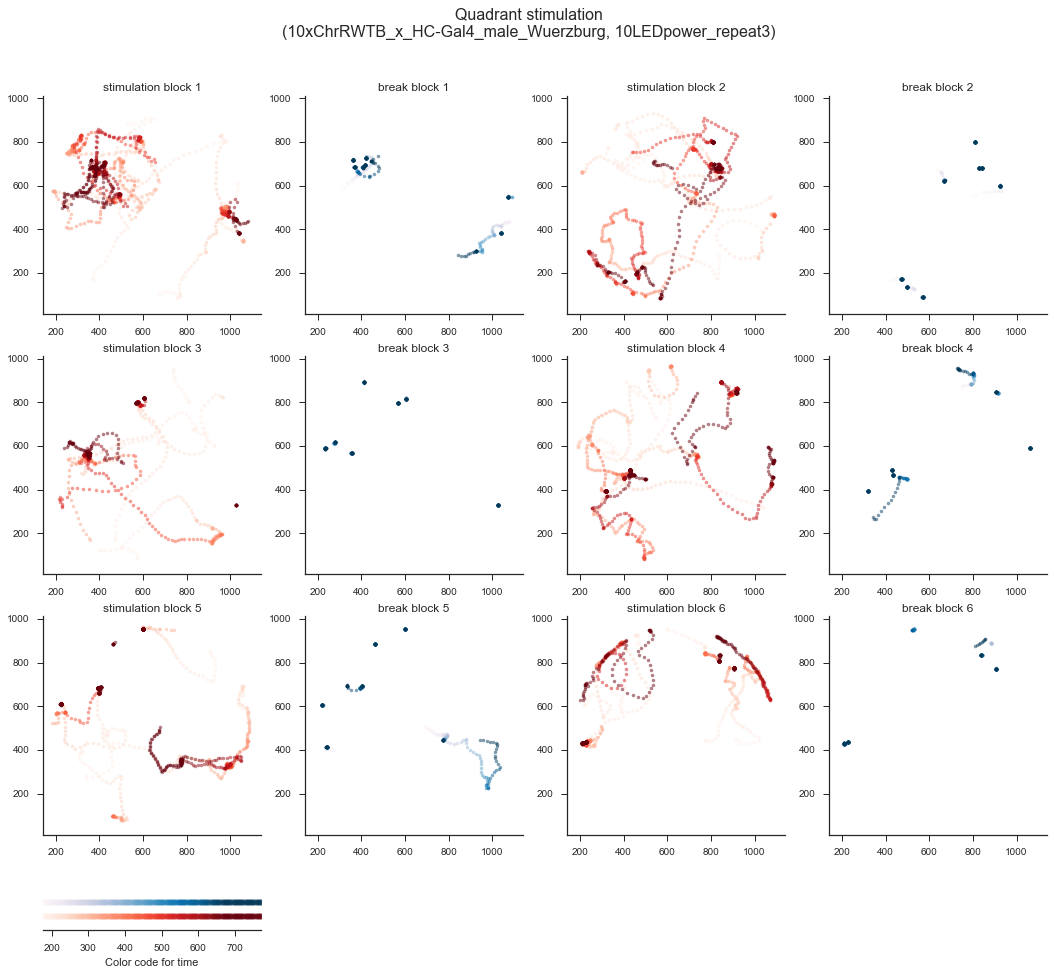

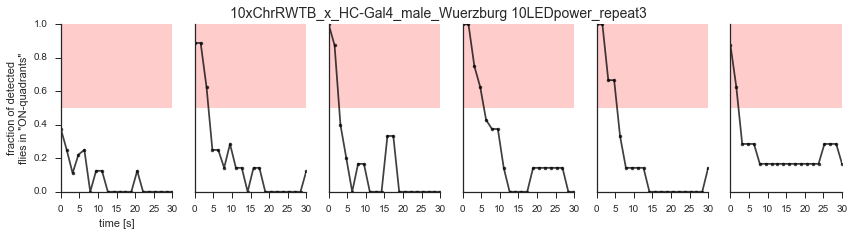

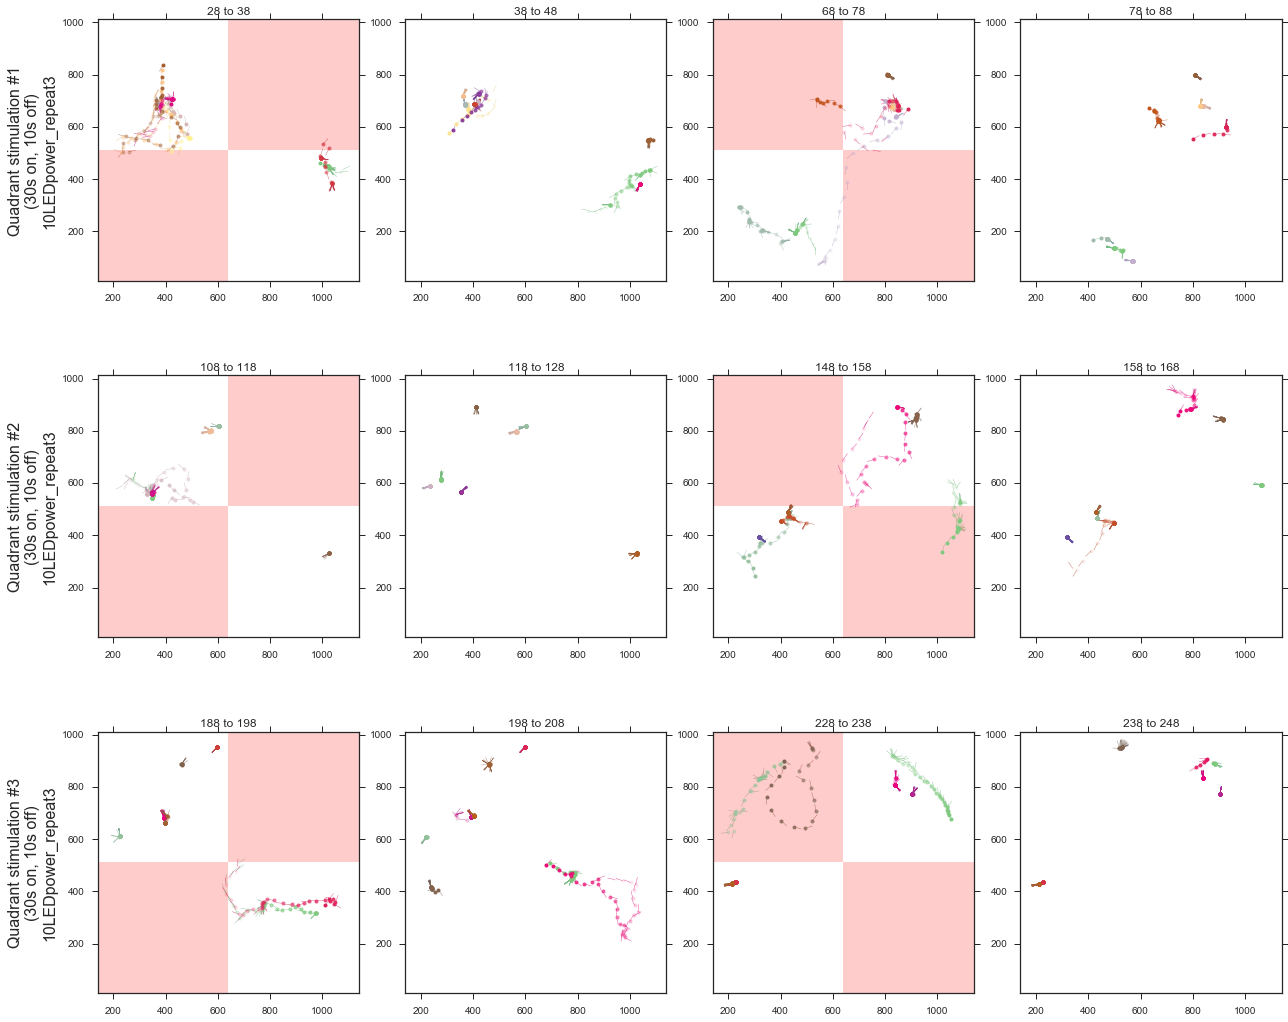

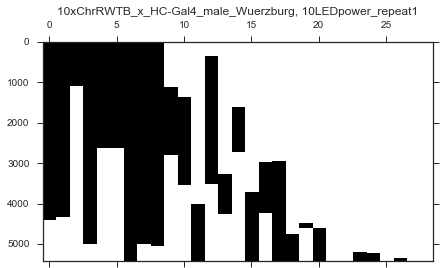

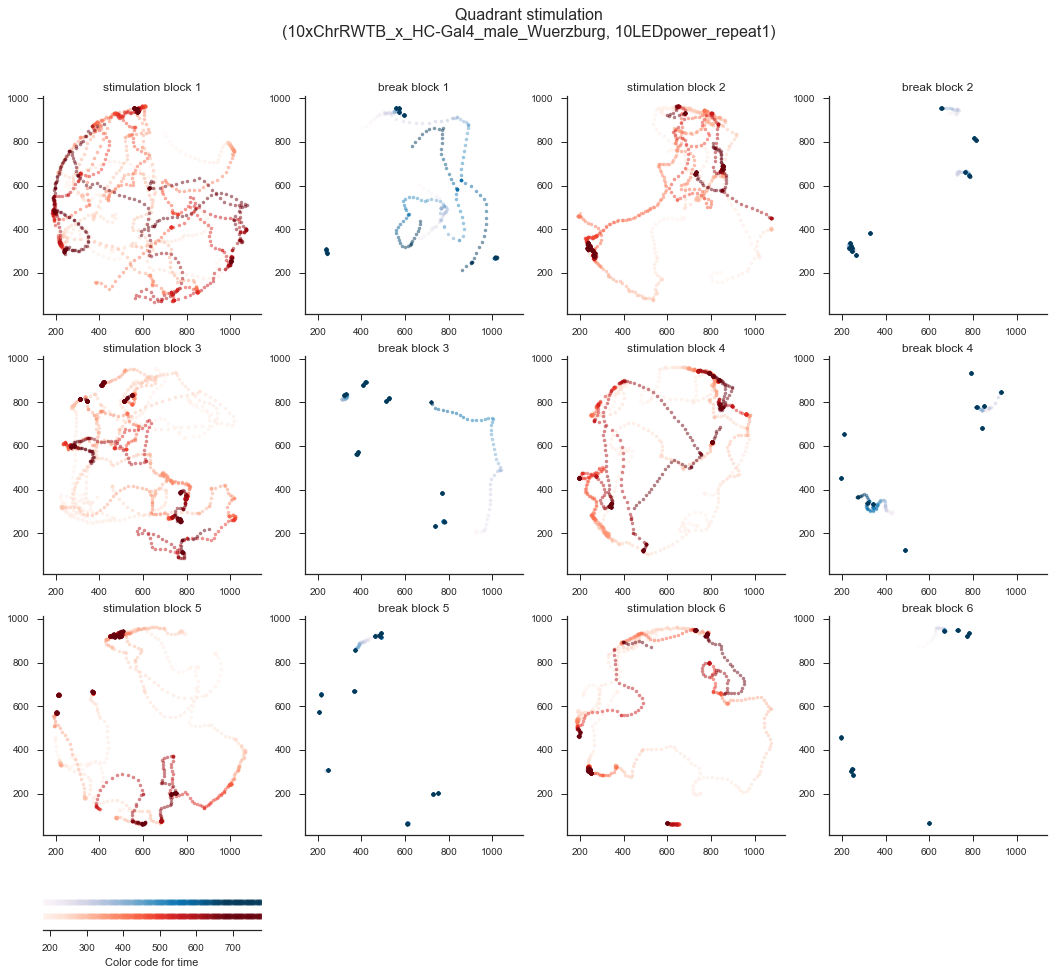

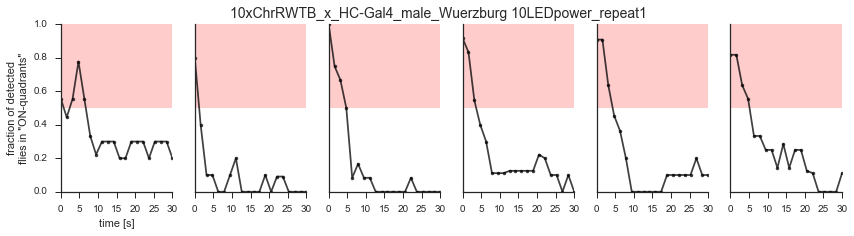

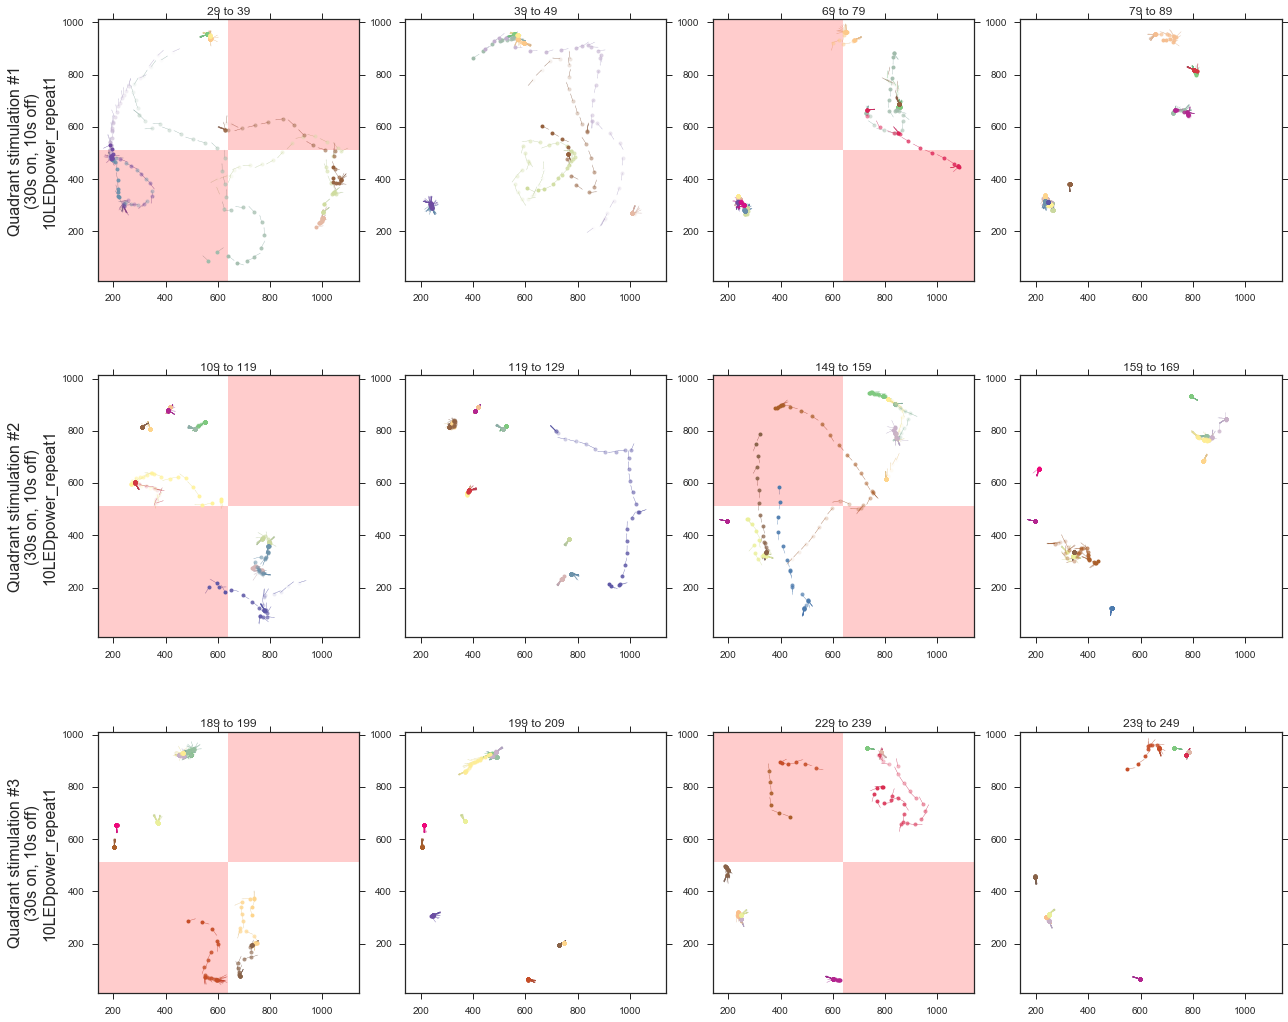

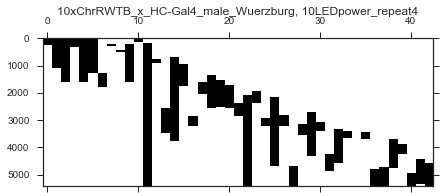

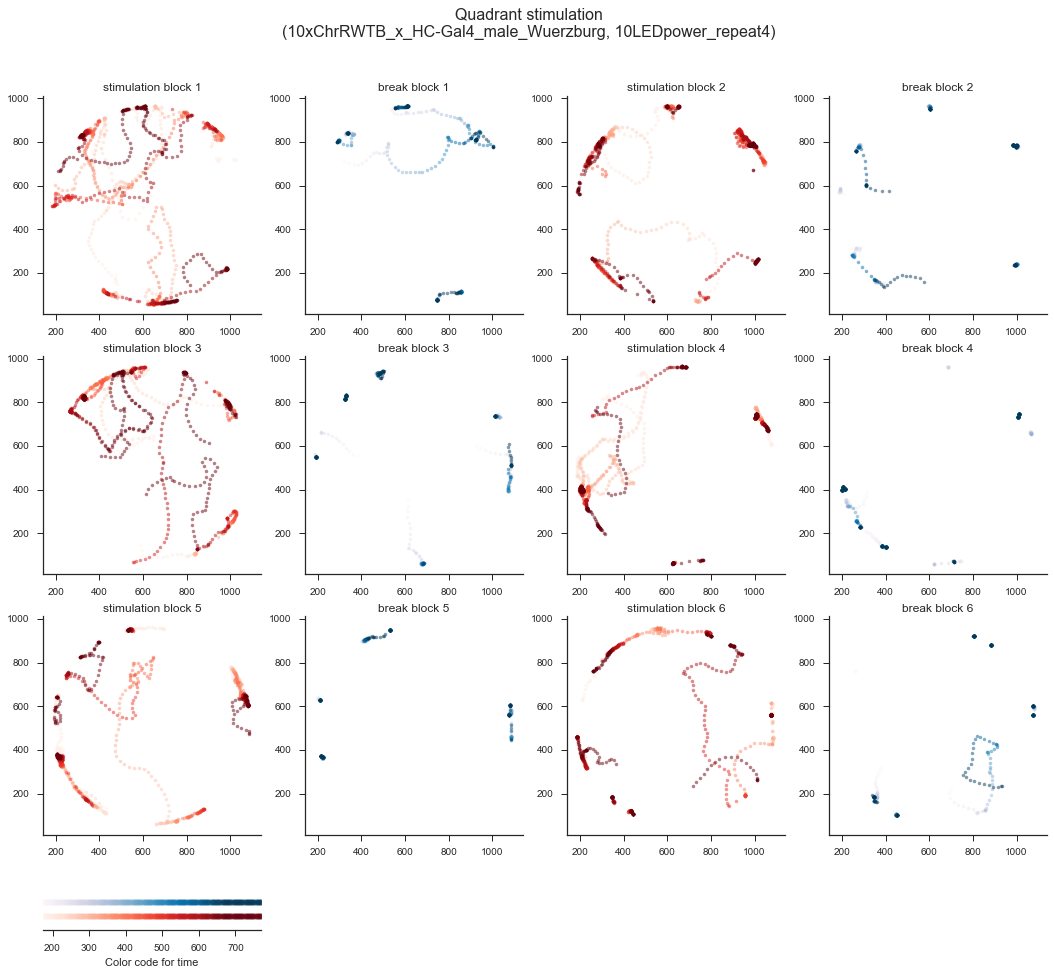

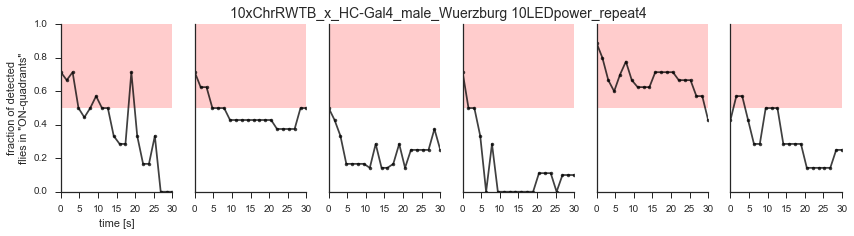

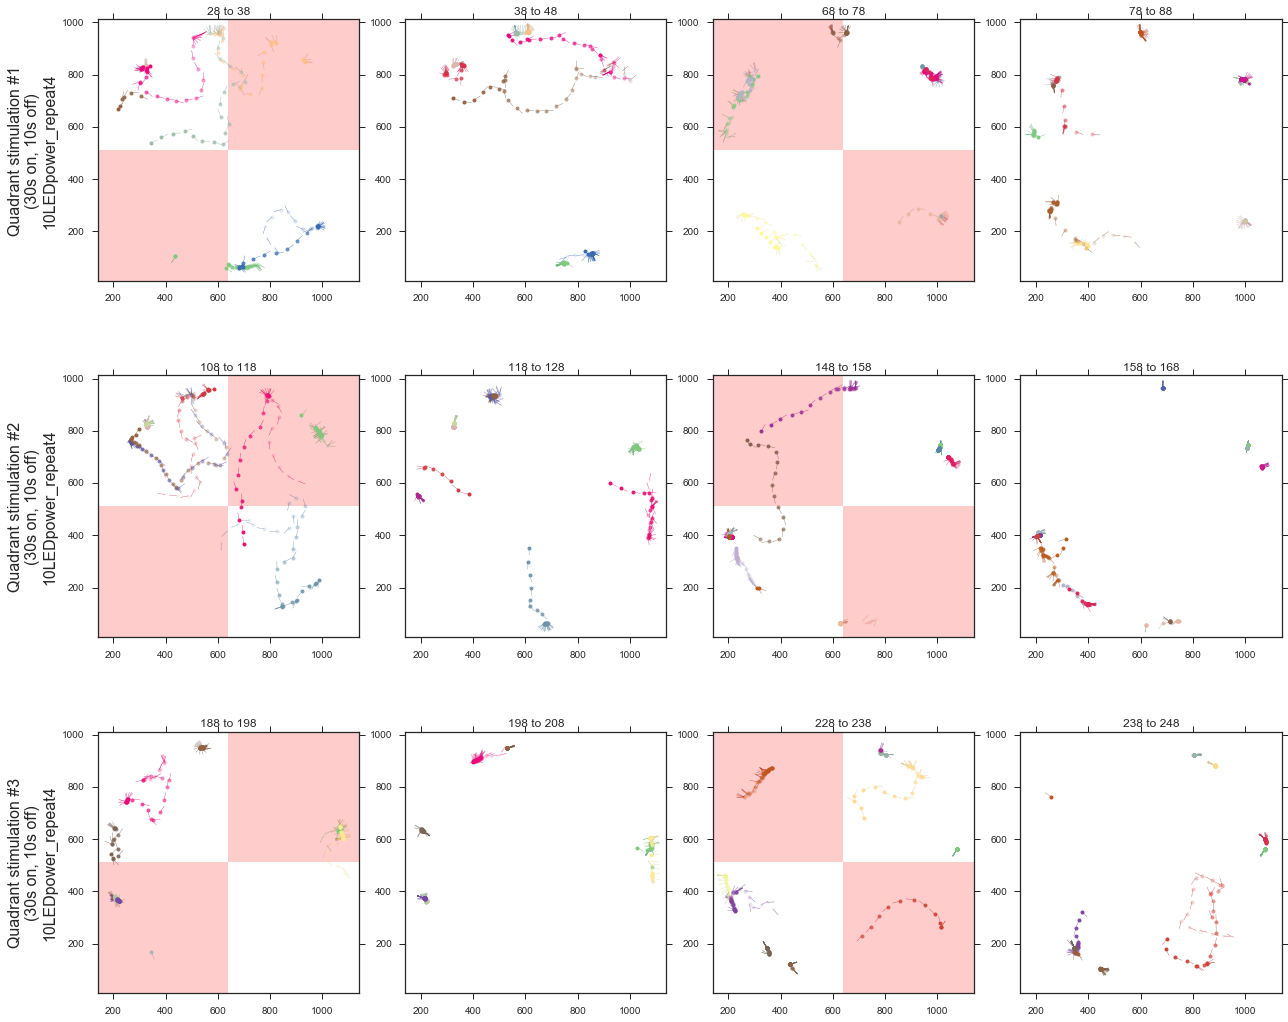

In [54]:
for repeat in range(len(fileNames)): #2,3,4,5,6 
    stimStartFrameQ = int(startFrames[repeat-1])
    fileName = fileNames[repeat-1]
    fileName

    stimStartFrameC = stimStartFrameQ + fps * 2 * numRepeatQ * (stimSecQ + pauseSecQ)  # NOT VERY PRECISE!

    #---------------------------------------
    fileNameParts = fileName.split('_')

    genotype = '_'.join(fileNameParts[0:fileNameParts.index('cam')-2])
    experiment =  '_'.join(fileNameParts[5:7])
    expName = '(' + genotype + ', ' + experiment + ')'

    print(genotype)
    print(experiment)

    plotSaveDir = analysisDir + '/' + genotype + '_' + experiment + '_plots'

    try:
        mkdir(plotSaveDir)
    except OSError:
        print('Experiment folder already exists')

    #---------------------------------------
    # Define masks (for the moment assume that arena is perfectly centered and 
    # that quadrants are squares. Need to read in image frame and extract shapes by using edges.)
    LEDon = np.ones((imageSizePx[0]/2,imageSizePx[1]/2))
    LEDoff = np.zeros((imageSizePx[0]/2,imageSizePx[1]/2))

    # first stimulation pattern
    patternA = np.hstack((np.vstack((LEDon,LEDoff)),np.vstack((LEDoff,LEDon))))

    # second stimulation pattern
    patternB = np.hstack((np.vstack((LEDoff,LEDon)),np.vstack((LEDon,LEDoff))))

    #patternFig = plt.figure()
    #ax1 = patternFig.add_subplot(121); plt.spy(patternA); ax1.set_title('pattern A\n')
    #ax2 = patternFig.add_subplot(122); plt.spy(patternB); ax2.set_title('pattern B\n')


    #---------------------------------------
    ### Import and rearrange data
    #---------------------------------------

    try:
        #load existing python file
        npzData = np.load(baseDir + fileName + '.npz')
        xPos = npzData['xPos']
        yPos = npzData['yPos']
        angle = npzData['angle']
        flyID = npzData['flyID']
        numFrames = len(xPos)
        maxFlyID = max(flyID)

    except:
        #load matlab data and convert
        indat = loadmat(baseDir + fileName + '.mat')

        dat = [indat[k] for k in keyList]

        # Reorganise fly position arrays into lists (sorted by frame)
        numFrames = len(dat[0])
        xPos = []
        yPos = []
        angle = []
        flyID = []

        pointer = 0
        for t in range(numFrames):
            numFlies = dat[3][t].astype('int')[0]

            xPos.append(dat[1][pointer:pointer+numFlies])
            yPos.append(dat[2][pointer:pointer+numFlies])
            angle.append(dat[5][pointer:pointer+numFlies])
            flyID.append(dat[4][pointer:pointer+numFlies])

            pointer += numFlies

        xPos = np.array(xPos)
        yPos = np.array(yPos)
        angle = np.array(angle)
        flyID = np.array(flyID)
        maxFlyID = max(dat[4])

        #save data for future sessions
        np.savez(baseDir + '/' + fileName + '.npz', 
                 xPos=xPos, yPos=yPos, angle=angle, flyID=flyID,maxFlyID=maxFlyID)

    #---------------------------------------
    ### Visualise tracking performance
    #---------------------------------------

    # Reorganise fly track fragments into matrix (frame x fly id )
    flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
    for frame in range(numFrames):
        fliesInFrame = np.array(flyID[frame]).squeeze().astype('int')
        if fliesInFrame.size == 1:
            flyIDperFrame[frame][fliesInFrame] = 1
        elif fliesInFrame.size > 1:
            for idx in fliesInFrame:
                flyIDperFrame[frame][idx] = 1

    #visualise resluting matrix
    fig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + ', ' + experiment + '\n')

    fig.savefig(plotSaveDir + '/' + fileName + '_traceFragments.pdf', format = 'pdf')

    #---------------------------------------
    ### Plot traces for each stimulation block (colour-coded time)
    #---------------------------------------

    #set frameBlocks
    skipFramesOFF = 3
    skipFramesON = 3

    def makeBeginIndexMatrix(stimStartFrame,numRepeat,stimS,pauseS):
        beginChr = np.array([[stimStartFrame + (repeat*stimS + repeat*pauseS) * fps, stimStartFrame + ((repeat+1)*stimS + repeat*pauseS) * fps]
                             for repeat in range(numRepeat)])
        return beginChr

    def makeEndIndexMatrix(stimStartFrame,numRepeat,stimS,pauseS):
        endChr = np.array([(stimStartFrame + ((repeat+1)*stimS + repeat*pauseS) * fps, stimStartFrame + ((repeat+1)*stimS + (repeat+1)*pauseS) * fps) 
                           for repeat in range(numRepeat)])
        return endChr

    #quadrant protocol
    beginChrQuadrant = makeBeginIndexMatrix(stimStartFrameQ,2*numRepeatQ,stimSecQ,pauseSecQ)
    endChrQuadrant = makeEndIndexMatrix(stimStartFrameQ,2*numRepeatQ,stimSecQ,pauseSecQ)
    framesToSkip = np.array([[skipFramesON,skipFramesOFF] for repeat in range(2*numRepeatQ)]) #repeat = 0...2*numRepeatQ-1

    chrQuadrantColor = np.array([['Reds','PuBu'] for repeat in range(2*numRepeatQ)]).ravel()
    chrQuadrant = np.vstack((beginChrQuadrant.ravel(),endChrQuadrant.ravel(),framesToSkip.ravel())).T

    #continuous protocol
    beginChrContinuous = makeBeginIndexMatrix(stimStartFrameC,numRepeatC,stimSecC,pauseSecC)
    endChrContinuous = makeEndIndexMatrix(stimStartFrameC,numRepeatC,stimSecC,pauseSecC)
    framesToSkip = np.array([[skipFramesON,skipFramesOFF] for repeat in range(numRepeatC)])

    chrContinuousColor = np.array([['Reds','PuBu'] for repeat in range(numRepeatC)]).ravel()
    chrContinuous = np.vstack((beginChrContinuous.ravel(),endChrContinuous.ravel(),framesToSkip.ravel())).T

    figQ = plotStimulationBlock_timeBar(chrQuadrant,chrQuadrantColor,
                                        'Quadrant stimulation\n' + expName,(18,15),numRepeatQ,imageSizePx)
    figQ.savefig(plotSaveDir + '/' + fileName + '_quadrantTrace.pdf', format = 'pdf')


    #---------------------------------------
    ### Fraction of flies in illuminated quadrants
    #---------------------------------------

    quadFractionFig = plt.figure(figsize=(14,3))
    numQuadRepeat = numRepeatQ*2

    for quadrantRepeat in range(numQuadRepeat):

        startFrame = stimStartFrameQ + quadrantRepeat*(stimSecQ+pauseSecQ)*fps

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        frameRange = range(startFrame,startFrame + stimSecQ*fps,30)
        time = np.linspace(0,stimSecQ,len(frameRange))

        fliesInLEDon = np.empty((len(frameRange),1))
        fractionInLEDon = np.empty((len(frameRange),1))

        for ind, frame in enumerate(frameRange):
            try:
                #assemble fly positions for frame
                spsData = np.ones((len(xPos[frame]),1)).squeeze()
                spsRowInds = np.array(xPos[frame].astype('int').squeeze())
                spsColInds = np.array(yPos[frame].astype('int').squeeze())
                
                if len(xPos[frame])<2:
                    flyLocations = np.zeros((imageSizePx[0],imageSizePx[1]))
                    flyLocations[spsRowInds,spsColInds] = spsData
                else:
                    flyLocations = sps.coo_matrix((spsData, (spsRowInds, spsColInds)),
                                                  shape=(imageSizePx[0],imageSizePx[1])).toarray()

                #check in wich pattern flies appear
                fliesInONpattern = (ONpattern + flyLocations)>1
                fliesInLEDon[ind] = sum(sum(fliesInONpattern))
                fractionInLEDon[ind] = sum(sum(fliesInONpattern))/sum(sum(flyLocations))

            except IndexError:
                print('movie too short')
                break

        subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
        subplt.plot(time,fractionInLEDon, marker = '.', linestyle = '-', color = 'black',alpha = 0.75)
        lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

        sns.despine(right=True,offset = 0)#trim=True)
        sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

        subplt.set_ylim((0,1)) 
        if(quadrantRepeat==0):
            subplt.set_xlabel('time [s]')
            subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
        else:
            subplt.set_yticks([])

    quadFractionFig.suptitle(genotype + ' ' + experiment + '\n', fontsize = 14)
    quadFractionFig.savefig(plotSaveDir + '/' + fileName + '_fractionInLEDon.pdf', format = 'pdf')


    #---------------------------------------
    ### Detailed traces during the quadrant trials
    #---------------------------------------

    def addQuadrantLightIndicator(indicatorSubPlt, imageSizePx, quadPattern):
        if quadPattern == 0:
            lightONindicator(indicatorSubPlt, 0, 0, imageSizePx[0]/2, imageSizePx[1]/2)
            lightONindicator(indicatorSubPlt, imageSizePx[0]/2, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
        else:
            lightONindicator(indicatorSubPlt, 0, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
            lightONindicator(indicatorSubPlt, imageSizePx[0]/2, 0, imageSizePx[0]/2, imageSizePx[1]/2)

    timeWindow = 10
    figSize = (18,15)
    skipFrames = 6
    fig = plt.figure(figsize = figSize);

    strtFrame = stimStartFrameQ
    for quadrantRepeat in range(0,numRepeatQ): #Quadrant Repeats

        for pat in range(2):
            #End of quadrant stimulation
            activeFragments_pre,fRange,titleString = defineQuadrantDetail(strtFrame,stimSecQ,timeWindow,fps,flyIDperFrame,skipFrames,'pre')

            subplt1 = fig.add_subplot(numRepeatQ, 4, 1 + pat*2 + quadrantRepeat*4)
            plotActiveSegments(activeFragments_pre,fRange,subplt1,titleString,xPos,yPos,angle,flyID,imageSizePx)

            #After quadrant stimulation
            activeFragments_post,fRange,titleString = defineQuadrantDetail(strtFrame,stimSecQ,timeWindow,fps,flyIDperFrame,skipFrames,'post')

            subplt2 = fig.add_subplot(numRepeatQ, 4, 2 + pat*2 + quadrantRepeat*4)
            plotActiveSegments(activeFragments_post,fRange,subplt2,titleString,xPos,yPos,angle,flyID,imageSizePx)

            #Add light ON indicators
            if (not pat):
                subplt1.set_ylabel('Quadrant stimulation #'+ str(quadrantRepeat+1) +
                                   '\n('+str(stimSecQ)+'s on, '+str(pauseSecQ)+'s off)\n' + experiment,fontsize = 16)

            addQuadrantLightIndicator(subplt1, imageSizePx, pat)

            #update start frame
            strtFrame = strtFrame + (stimSecQ+pauseSecQ)*fps

    fig.tight_layout()
    fig.savefig(plotSaveDir + '/' + fileName + '_detail.pdf', format = 'pdf')

In [55]:
ledpow = 'LED10'
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/\
10xChrRWTB_x_HC-Gal4_male_Wuerzburg/'+ledpow+'/'

fpss = [20,20,20,20,20,20] #frame rates in each movie
imageSizePxs = [(1280,1024),(1280,1024),(1280,1024),(1280,1024),(1280,1024),(1280,1024)] #image sizes in each movie
numRep = len(fpss)

analysisDir = baseDir

expListFile = baseDir + 'firstFrames.csv'
print('Reading in stimulation start frame list from ' + expListFile)

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []

for line in csv_fileList:
    fileNames.append(line[1])
    startFrames.append(line[2])

numQuadRepeat = numRepeatQ*2
windowSize = stimSecQ

fractionInLEDonAll = np.zeros((numRep, numQuadRepeat, windowSize))
time = np.linspace(0,stimSecQ,windowSize)

genotype = baseDir.split('/')[-4]

print(genotype)

try:
    mkdir(plotSaveDir)
except OSError:
    print('Experiment folder already exists')

for repeat in range(1,numRep+1):
    print(repeat)
    fps = fpss[repeat-1]
    imageSizePx = imageSizePxs[repeat-1]
    stimStartFrameQ = int(startFrames[repeat-1])
    fileName = fileNames[repeat-1]

    stimStartFrameC = stimStartFrameQ + fps * 2 * numRepeatQ * (stimSecQ + pauseSecQ)  # NOT VERY PRECISE!

    #---------------------------------------
    # Define masks (for the moment assume that arena is perfectly centered and 
    # that quadrants are squares. Need to read in image frame and extract shapes by using edges.)
    LEDon = np.ones((imageSizePx[0]/2,imageSizePx[1]/2))
    LEDoff = np.zeros((imageSizePx[0]/2,imageSizePx[1]/2))

    # first stimulation pattern
    patternA = np.hstack((np.vstack((LEDon,LEDoff)),np.vstack((LEDoff,LEDon))))

    # second stimulation pattern
    patternB = np.hstack((np.vstack((LEDoff,LEDon)),np.vstack((LEDon,LEDoff))))

    #---------------------------------------
    ### Import data
    #---------------------------------------

    indat = loadmat(baseDir + fileName + '.mat')

    dat = [indat[k] for k in keyList]

    # Reorganise fly position arrays into lists (sorted by frame)
    numFrames = len(dat[0])
    xPos = []
    yPos = []
    angle = []
    flyID = []

    pointer = 0
    for t in range(numFrames):
        numFlies = dat[3][t].astype('int')[0]

        xPos.append(dat[1][pointer:pointer+numFlies])
        yPos.append(dat[2][pointer:pointer+numFlies])
        angle.append(dat[5][pointer:pointer+numFlies])
        flyID.append(dat[4][pointer:pointer+numFlies])

        pointer += numFlies

    xPos = np.array(xPos)
    yPos = np.array(yPos)
    angle = np.array(angle)
    flyID = np.array(flyID)
    maxFlyID = max(dat[4])
 
    #---------------------------------------
    ### Fraction of flies in illuminated quadrants
    #---------------------------------------
    for quadrantRepeat in range(numQuadRepeat):

        startFrame = stimStartFrameQ + quadrantRepeat*(stimSecQ+pauseSecQ)*fps

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        frameRange = range(startFrame,startFrame + windowSize*fps,1)

        fliesInLEDon = np.empty((len(frameRange),1))
        fractionInLEDon = np.empty((len(frameRange),1))

        for ind, frame in enumerate(frameRange):
            try:
                #assemble fly positions for frame
                spsData = np.ones((len(xPos[frame]),1)).squeeze()
                spsRowInds = np.array(xPos[frame].astype('int').squeeze())
                spsColInds = np.array(yPos[frame].astype('int').squeeze())

                if len(xPos[frame])<2:
                    flyLocations = np.zeros((imageSizePx[0],imageSizePx[1]))
                    flyLocations[spsRowInds,spsColInds] = spsData
                else:
                    flyLocations = sps.coo_matrix((spsData, (spsRowInds, spsColInds)),
                                                  shape=(imageSizePx[0],imageSizePx[1])).toarray()

                #check in wich pattern flies appear
                fliesInONpattern = (ONpattern + flyLocations)>1
                fliesInLEDon[ind] = sum(sum(fliesInONpattern))
                fractionInLEDon[ind] = sum(sum(fliesInONpattern))/sum(sum(flyLocations))

            except IndexError:
                print('movie too short')
                break
                
        #downsample per to 1 Hz
        for ind,frame in enumerate(range(0,windowSize*fps,fps)):
            fractionInLEDonAll[repeat-1,quadrantRepeat,ind] = np.median(np.squeeze(fractionInLEDon[frame:frame+fps]))
    
np.save(baseDir+'fractionInLEDonAll',fractionInLEDonAll)

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED10/firstFrames.csv
virtualReinforcement
Experiment folder already exists
1
2
3
4
5
6


In [56]:
%matplotlib inline

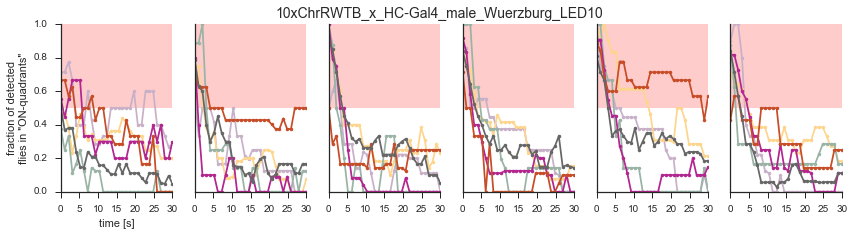

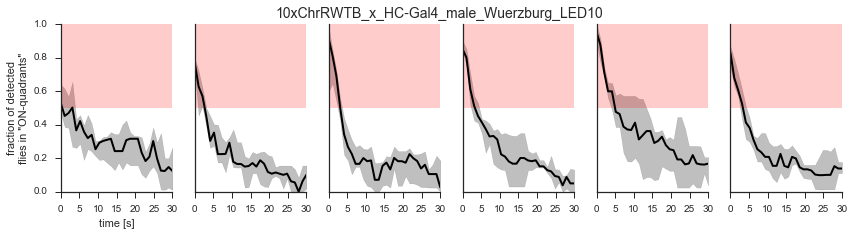

In [59]:
ledpow = 'LED10'
numRep = 6
currledLevelColor = ledLevelColor[0]
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/\
10xChrRWTB_x_HC-Gal4_male_Wuerzburg/'+ledpow+'/'

genotype = baseDir.split('/')[-3]
plotSaveDir = baseDir + genotype + '_' + ledpow + '_plots'

try:
    mkdir(plotSaveDir)
except OSError:
    print('Experiment folder already exists')

fractionInLEDonAll = np.load(baseDir + genotype + '_' + ledpow + '_fractionInLEDonAll.npy')

#---------------------------------------
import matplotlib.colors as colors
import matplotlib.cm as cmx

sns.set_style('ticks')

cNorm  = colors.Normalize(vmin=0, vmax=numRep)
repMap = cmx.ScalarMappable(norm=cNorm, cmap='Accent')

quadFractionFig = plt.figure(figsize=(14,3))

for quadrantRepeat in range(numQuadRepeat):

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    subplt.set_ylim((0,1)) 
    if(quadrantRepeat==0):
        subplt.set_xlabel('time [s]')
        subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
    else:
        subplt.set_yticks([])

for repeat in range(1,numRep+1):

    for quadrantRepeat in range(numQuadRepeat):

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
        subplt.plot(time,fractionInLEDonAll[repeat-1,quadrantRepeat,:], marker = '.', 
                    linestyle = '-', color = repMap.to_rgba(repeat),alpha=1)
        

quadFractionFig.suptitle(genotype + '_' + ledpow +'\n', fontsize = 14)
quadFractionFig.savefig(plotSaveDir + '/' + genotype + '_' + ledpow + '_fractionInLEDon.pdf', format = 'pdf')

quadFractionFig = plt.figure(figsize=(14,3))

for quadrantRepeat in range(numQuadRepeat):

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    subplt.set_ylim((0,1)) 
    if(quadrantRepeat==0):
        subplt.set_xlabel('time [s]')
        subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
    else:
        subplt.set_yticks([])

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB
    
    meanResp = np.nanmedian(fractionInLEDonAll[:,quadrantRepeat,:],0).transpose()
    q75, q25 = np.nanpercentile(fractionInLEDonAll[:,quadrantRepeat,:], [75 ,25], axis=0)

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    subplt.plot(time,meanResp, linestyle = '-', color = currledLevelColor,alpha=1, linewidth=2)
    subplt.fill_between(time, q25, q75, color=currledLevelColor, alpha=0.25)
    

quadFractionFig.suptitle(genotype + '_' + ledpow +'\n', fontsize = 14)
quadFractionFig.savefig(plotSaveDir + '/' + genotype + '_' + ledpow + '_fractionInLEDon_median.pdf', format = 'pdf')

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED01/firstFrames.csv
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
Experiment folder already exists
Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED05/firstFrames.csv
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
Experiment folder already exists
Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/10xChrRWTB_x_HC-Gal4_male_Wuerzburg/LED10/firstFrames.csv
10xChrRWTB_x_HC-Gal4_male_Wuerzburg
Experiment folder already exists


/Users/hannah/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 3 results
  RuntimeWarning)


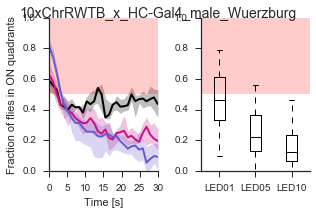

In [61]:
genotype = '10xChrRWTB_x_HC-Gal4_male_Wuerzburg'
ledpows = ['LED01','LED05','LED10']

allbxPltVals = []
rootDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/'

quadFractionCompareFig = plt.figure(figsize=(4.5,3))
quadFractionCompareFig.suptitle(genotype+'\n', fontsize = 14)

gs = gridspec.GridSpec(1,2,width_ratios=[1,1])

sns.set_style('ticks')

subplt = quadFractionCompareFig.add_subplot(gs[0])
subplt.set_ylim((0,1)) 
subplt.set_xlabel('Time [s]')
subplt.set_ylabel('Fraction of flies in ON quadrants')
lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

sns.despine(right=True,offset = 0)
sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

for ledpowlevel in range(len(ledpows)):
    ledpow = ledpows[ledpowlevel]
    baseDir = rootDir+genotype+'/'+ledpow+'/'
    currLedColor = ledLevelColor[ledpowlevel]

    analysisDir = baseDir

    expListFile = baseDir + 'firstFrames.csv'
    print('Reading in stimulation start frame list from ' + expListFile)

    # load file specifying data to be analysed
    fractionInLEDonAll = np.load(baseDir + genotype + '_' + ledpow + '_fractionInLEDonAll.npy')

    numQuadRepeat = numRepeatQ*2
    windowSize = 30

    time = np.linspace(0,stimSecQ,windowSize)

    plotSaveDir = analysisDir + '/' + genotype + '_' + ledpow + '_plots'
    print(genotype)

    try:
        mkdir(plotSaveDir)
    except OSError:
        print('Experiment folder already exists')
    
    # average fraction 
    allmeanResp = np.nanmedian(np.median(fractionInLEDonAll[:,:,:],1),0)
    q75, q25 = np.nanpercentile(np.median(fractionInLEDonAll[:,:,:],1), [75 ,25], axis=0)
    subplt.plot(time,allmeanResp, linestyle = '-', color = currLedColor,alpha=1, linewidth=2)
    subplt.fill_between(time, q25, q75, color = currLedColor, alpha=0.25)

    # for boxplot (take last 10 s)
    medianTrialResp = np.median(fractionInLEDonAll[:,:,:],1)
    bxPltVals = np.mean(fractionInLEDonAll[:,:,19:-1],2)
    allbxPltVals.append(np.ravel(bxPltVals))

subplt = quadFractionCompareFig.add_subplot(gs[1])
lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

sns.despine(right=True,offset = 0)
sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

subplt.set_ylim((0,1)) 
bp = subplt.boxplot(allbxPltVals,notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.xticks(range(1,4),ledpows)

quadFractionCompareFig.tight_layout()
quadFractionCompareFig.savefig(rootDir + genotype + '/' + genotype +'_fractionInLEDon.pdf', format = 'pdf')

In [62]:
for ledpowlevel in range(len(ledpows)):
    np.savetxt(rootDir+genotype+'/boxplotdata_LED'+str(ledpowlevel)+'.csv', allbxPltVals[ledpowlevel], delimiter=",")

In [63]:
statsLED01 = ttest_1samp(allbxPltVals[0],0.5)
print('LED 1%: ' + str(statsLED01[1]))

statsLED05 = ttest_1samp(allbxPltVals[1],0.5)
print('LED 5%: ' + str(statsLED05[1]))

statsLED10 = ttest_1samp(allbxPltVals[2],0.5)
print('LED 10%: ' + str(statsLED10[1]))


LED 1%: 0.18533102548
LED 5%: 3.18162819735e-10
LED 10%: 3.62695135118e-16


### Function definitions (in order of apprearance)

In [9]:
def plotSparseMatrix(figsize,aspectRatio,matrixToPlot,titleString):
    fig = plt.figure(figsize = figsize)
    fig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    ax = fig.add_subplot(111)
    
    ax.spy(matrixToPlot)
    ax.set_aspect(aspectRatio)
    ax.set_title(titleString)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    return fig

In [10]:
def plotPosInRange(ax,frameRange,xPos,yPos,currCmap,imageSizePx):
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for frame in frameRange:
        try:
            ax.plot(xPos[frame],yPos[frame],marker='.',linestyle='none',alpha=0.5, 
                    color=scalarMap.to_rgba(frame-frameRange[0]))
        except IndexError:
            print('movie too short')
            break
    
    ax.set_aspect('equal')
    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    plt.xlim([imageSizePx[0]/2.0 - 500,imageSizePx[0]/2.0 + 500]);
    plt.ylim([imageSizePx[1]/2.0 - 500,imageSizePx[1]/2.0 + 500]);

In [11]:
def plotStimulationBlock(fig,figGridSpace,blockFrames,blockColors,colNumber,rowNumber,imageSizePx):
    
    for block in range(len(blockFrames)):
        frames = range(blockFrames[block][0],blockFrames[block][1],blockFrames[block][2])
        subplt = fig.add_subplot(figGridSpace[block])
        plotPosInRange(subplt,frames,xPos,yPos,blockColors[block],imageSizePx)
        if(block%2):#odd
            subplt.set_title('break block ' + str(block/2 + 1))
        else:
            subplt.set_title('stimulation block ' + str(block/2 + 1))

    return fig

In [12]:
def defineQuadrantDetail(strtFrame, stimSecQ, timeWindow, fps, flyIDperFrame, skipFrames, windowType):

    if windowType == 'pre':
        fRange = range(strtFrame + (stimSecQ-timeWindow)*fps, strtFrame + stimSecQ*fps,skipFrames)
        titleString = str(strtFrame/fps + (stimSecQ-timeWindow)) + ' to ' + str(strtFrame/fps + stimSecQ)
    elif windowType == 'post':
        fRange = range(strtFrame + stimSecQ*fps, strtFrame + (stimSecQ+timeWindow)*fps,skipFrames)
        titleString = str(strtFrame/fps + stimSecQ) + ' to ' + str(strtFrame/fps + (stimSecQ+timeWindow))
    else:
        print('Invalid window type')
        return

    try:
        activeFragments = np.array(np.nonzero(sum(flyIDperFrame[fRange]))).squeeze()
    except IndexError:
        print('movie too short')
        activeFragments = np.empty((1,1))

    return activeFragments, fRange, titleString

In [13]:
def plotStimulationBlock_timeBar(blockFrames,blockColors,title,figureSize,colNumber,imageSizePx):
    
    blockfig = plt.figure(figsize = figureSize)
    blockfig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    blockfig.suptitle(title,fontsize = 16)
    
    rowNumber = len(blockFrames)/colNumber
    gs = gridspec.GridSpec(colNumber+1,rowNumber, height_ratios=np.hstack((np.repeat(4,colNumber),1))) 
    blockfig = plotStimulationBlock(blockfig,gs,blockFrames,blockColors,colNumber+1,rowNumber,imageSizePx)
        
    #time color code
    timeplt = blockfig.add_subplot(gs[len(blockFrames):len(blockFrames)+1])
    frameRange = range(blockFrames[0][0],blockFrames[0][1],blockFrames[0][2])
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
        
    for col in range(2):
        for frame in frameRange:
            scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=blockColors[col])
            timeplt.plot(frame,0.5*col+1 ,marker='.',markersize=12,linestyle='none',alpha=0.5,
                         color=scalarMap.to_rgba(frame-frameRange[0])) 
    
    timeplt.get_xaxis().tick_bottom()
    timeplt.get_yaxis().set_visible(False)
    timeplt.spines['top'].set_visible(False)
    timeplt.spines['right'].set_visible(False)
    timeplt.spines['left'].set_visible(False)
    plt.xlim([frameRange[0],frameRange[-1]]);
    plt.ylim([0.5,2.5]);
    plt.xlabel('Color code for time')
    
    return blockfig

In [14]:
def lightONindicator(subplt,x,y,width,height):
    subplt.add_patch(
        patches.Rectangle(
             (x,y), width, height,
            alpha = 0.2, facecolor = 'red', edgecolor = 'none'
        )
    )

In [15]:
def plotActiveSegments(activeFragments,frameRange,subplt,titleString,xPos,yPos,angle,flyID,imageSizePx):
    if(sum(activeFragments).squeeze() == 0):
        return
    
    flyRange = range(min(activeFragments),max(activeFragments)+1)

    cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments+1))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

    arrowScale = 5
    
    for currFly in flyRange:
        counter = 0.0
        for frame in frameRange:
            currX = xPos[frame][flyID[frame] == currFly]
            currY = yPos[frame][flyID[frame] == currFly]
            
            try:
                newArrow = patches.Arrow(currX.squeeze(), currY.squeeze(), np.cos(angle[frame][flyID[frame] == currFly]).squeeze()*30,
                                         np.sin(angle[frame][flyID[frame] == currFly]).squeeze()*30, width=2,
                                         edgecolor = scalarMap.to_rgba(currFly),alpha = 0.5)
                subplt.add_patch(newArrow)
            except:
                continue
                
            subplt.plot(currX,currY, marker='.',color=scalarMap.to_rgba(currFly), markersize=8,
                        alpha = 1-counter/(len(frameRange)))
            
            counter +=1.0
    subplt.set_aspect('equal')
    subplt.set_title(titleString) 
    
    plt.xlim([imageSizePx[0]/2 - 500,imageSizePx[0]/2 + 500]);
    plt.ylim([imageSizePx[1]/2 - 500,imageSizePx[1]/2 + 500]);
    
    return